# Data Encoding Analysis

*Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

## Overview

Many studies are now exhibiting the promise of Variational Quantum Algorithms (VQA) in demonstrating quantum advantages on near-term quantum devices, with particular emphasis on using them to solve supervised learning tasks. VQA is also known as a Parameterized Quantum Circuit (PQC), which is divided into two main parts in this tutorial: the data encoding circuit and the quantum neural network. The data encoding circuit converts classical data into quantum states, and the quality of the quantum states has a direct impact on the classification results. When data encoding is analyzed through the perspective of kernel functions, different encoding methods correspond to different kernel functions, which play a critical role in the classification of quantum states [1,2]. It often determines the expressiveness and generalization ability of the method by analyzing data encoding from the standpoint of statistical learning theory [3,4]. Therefore, it is necessary to conduct a systematic analysis of data encoding. From the standpoint of quantum information, literature [5] critically analyzes the effect of the width and depth of the data encoding circuit on the quantum state.

The next part of the tutorial is organized around the literature [5] and is divided into two parts: theory and Paddle Quantum implementation. The fundamental concepts and main conclusions are introduced first, followed by specific implementation solutions.

## Theory

### Fundamental Concepts

Figure 1 shows the flowchart for encoding classical data into quantum states. Assume that the classical data are independent identically distributed samples of distribution $D$, each classical data is $\pmb x$, which becomes a quantum state $\rho(\pmb x)$ after passing through the data encoding circuit. Here the concept of **average quantum state** over the distribution $D$ is introduced, i.e. 

$$
\bar{\rho}:=\mathbf{E}[\rho(\pmb x)]. \tag{1}
$$

Given a classical data set $S$ consisting of $M$ data, we usually use the average value to approximate the average quantum state of $S$

$$
\bar{\rho}:=\frac{1}{M}\sum_{j=1}^M\rho(\pmb x_j). \tag{2}
$$


![illustration](figures/EncodingAnalysis-fig-illustration.png  "Figure 1: Flowchart for encoding classical data into quantum states.")

There are various methods for measuring the distance between quantum states, including trace distance, fidelity, **Petz-Rényi divergence**, and others. In this tutorial, the Petz-Rényi divergence is used as a measure of the distance between different quantum states. Specifically, the Petz-Rényi divergence of the quantum states $\rho_0$ and $\rho_1$ is defined as

$$
D_2(\rho_0||\rho_1)=logTr[\rho_0^2\rho_1^{-1}], \tag{3}
$$

the closer the two quantum states are, the smaller the value of $D_2$.

### Main Result

The Petz-Rényi divergence metric is then used to calculate the distance between the encoding average quantum state and the maximum mixed state. It is not difficult to believe that this distance is related to the property of the classical dataset and how the data are encoded. Assume that each feature dimension of the classical dataset satisfies certain independence and has a standard deviation of at least $\sigma$. The following inequality then holds for the encoding circuit depicted in figure 2 (with width and depth $n$ and $D$, respectively)

$$
D_2(\bar{\rho}||I/2^n)\leq log(1+(2^n-1)2^{-D\sigma^2}), \tag{4}
$$

where $I/2^n$ is the maximum mixed state of $n$ bits and $I$ is the unit matrix.

![encoding-u3](figures/EncodingAnalysis-fig-u3_circuit.png " Figure 2: General data encoding circuits. Etg denotes any combination of control non-gates and CZ gates.")

A more rigorous description and proof of the theorem can be found in [5], and the focus of this tutorial will be on what this conclusion implies and illuminates.

* This means that the average quantum state converges to the maximum mixed state at an exponential rate as the circuit depth increases. For example, if the average quantum states of both classes 0 and 1 eventually converge to the maximum mixed state, it will be impossible to distinguish the average quantum states of these two classes from the standpoint of quantum information, i.e., it will be impossible to distinguish classical data features in an average sense.

* When the classical data features have a high dimensionality (e.g., picture data), angle encoding may not be the best option. This is due to the fact that it can easily lead to very deep encoding circuits, and widening circuits may run into the barren plateau problem, which severely limits VQA's capability. As a result, some dimensionality reduction operations must be performed on the traditional data before it is fed into the circuit.

## Paddle Quantum Implementation

This section focuses on two experiments using Paddle Quantum on the MNIST dataset: 
- Exploring the trend of the Petz-Rényi divergence between the average quantum state and the maximum mixed state with the depth of the data encoding circuit
- Investigate changes in classification accuracy as the data encoding circuit becomes deeper.

### First import the relevant packages

In [2]:
# import numpy, paddle, and paddle_quantum
import numpy as np
import paddle
import paddle_quantum

# import circuit module
from paddle_quantum.ansatz import Circuit

# import some function
from numpy import pi as PI
from paddle import matmul, transpose, reshape, real, argmax, cast, mean, concat, real
from paddle_quantum.qinfo import pauli_str_to_matrix 
from paddle_quantum.linalg import dagger
import paddle.nn.functional as F

# dataset tool
from paddle_quantum.dataset import MNIST

# plot and time module
from matplotlib import pyplot as plt
from pylab import axes
import time

### Parameterized Quantum Circuit

![encoding-ry](figures/EncodingAnalysis-fig-ry_circuit.png "Figure 3: Parameterized quantum circuit.")

The red box on the left in Figure 3 is the data encoding circuit, a special case of Figure 2, and the blue box on the right is the quantum neural network. The data encoding circuit here is made up of $R_y$ and CNOT, and the specific circuit depth $D$ is determined by the data feature dimension. The MNIST dataset will be used in this tutorial and the images are downscaled to 16-dimensional feature vectors. The number of quantum bits is chosen to be 8, 6, 4, 3, 2, and the corresponding circuit depths are 2, 3, 4, 6, 8. The positions larger than 16 dimensions will be filled with 0, i.e., $R_y(0)$. The quantum neural network part consists of the single-bit universal gate $U3$ and CNOT.
The specific circuit depth $L$ can be set freely.

### Encoding classical Data into quantum states

Here you need the dataset tool `dataset` provided by Paddle Quantum. The MNIST data are encoded into quantum states using the data encoding circuit shown in Figure 2 before being fed into the quantum neural network for training.

In [4]:
train_data, test_data = [], []

# Binary classification task 
classes = [3,6]

training_data_num = 1000
testing_data_num = 200
qubit_num_list = [8, 6, 4, 3, 2]

# Encode classical data using circuits of different widths and depths and save them
for qubit_num in qubit_num_list:
    
    # training dataset
    train_dataset = MNIST(mode='train', encoding='real_entangled_encoding', num_qubits=qubit_num,
                          classes=classes,
                          data_num=training_data_num,
                          downscaling_method='resize', target_dimension=16,
                          need_relabel=True, return_state=True)

    # validation dataset
    val_dataset = MNIST(mode='test', encoding='real_entangled_encoding', num_qubits=qubit_num,
                        classes=classes,
                        data_num=testing_data_num,
                        downscaling_method='resize', target_dimension=16,
                        need_relabel=True, return_state=True)

    # x and y
    train_x, train_y = train_dataset.quantum_image_states, train_dataset.labels
    test_x, test_y = val_dataset.quantum_image_states, val_dataset.labels
    train_data.append((train_x, train_y))
    test_data.append((test_x, test_y))

In [5]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)
print(test_data[0][0].shape)
print(test_data[0][1].shape)

[1000, 256]
(1000,)
[200, 256]
(200,)


### Building Quantum Neural Network

In [6]:
# Construct model
class Net(paddle.nn.Layer):
    """
    construct network
    """
    def __init__(self, n, depth):
        # Initialize the circuit: n, depth
        super(Net, self).__init__()
        self.n = n
        self.depth = depth
        
        self.circuit = Circuit(n)
        # Add layers of rotation gates
        for i in range(n):
            self.circuit.rz(qubits_idx=i)
            self.circuit.ry(qubits_idx=i)
            self.circuit.rz(qubits_idx=i)

        # default depth = 1
        # Add layers of entanglement
        for d in range(3, depth + 3):
            for i in range(n-1):
                self.circuit.cnot(qubits_idx=[i, i + 1])
            self.circuit.cnot(qubits_idx=[n-1, 0])
            for i in range(n):
                self.circuit.ry(qubits_idx=i)

    # Define forward propagation mechanism, and then calculate loss function and cross-validation accuracy
    def forward(self, state_in, label):
        """
        Input: 
            state_in: input quantum state, shape: [-1, 1, 2^n] -- Here is [BATCH, 1, 2^n]
            label: labels of input quantum state, shape: [-1, 1]
        Loss function:
            The cross entropy loss 
        """
        # Initialize theta 
        Utheta = self.circuit.unitary_matrix()

        # row vector operations here to speed up 
        state_out = matmul(state_in, Utheta)  # shape [-1, 1, 2 ** n]

        # Measure the expected value of the pauli Z operator <Z>
        Ob1 = paddle.to_tensor(pauli_str_to_matrix([[1.0, 'z0']], self.n))
        E_Ob1 = matmul(matmul(state_out, Ob1), transpose(paddle.conj(state_out), perm=[0, 2, 1]))
        E_Ob1_re = reshape(real(E_Ob1), [-1, 1])

        Ob2 = paddle.to_tensor(pauli_str_to_matrix([[1.0, 'x0']], self.n))
        E_Ob2 = matmul(matmul(state_out, Ob2), transpose(paddle.conj(state_out), perm=[0, 2, 1]))
        E_Ob2_re = reshape(real(E_Ob2), [-1, 1])

        outputs = concat([E_Ob1_re, E_Ob2_re], axis=-1)
    
        # Calculate loss and accuracy
        loss = F.cross_entropy(outputs, label)
        acc = mean(cast(argmax(outputs, axis=-1) == label, "float32"))
        
        return loss, acc

In [7]:
# Define a classifier
def QClassifier(train_x, train_y, test_x, test_y, N, D, EPOCH, LR, BATCH, seed=0):
    """
    Quantum binary classifier
    """
    train_y = paddle.to_tensor(train_y, dtype="int64")
    test_y = paddle.to_tensor(test_y, dtype="int64")

    N_train, in_dim = train_x.shape
    
    # Initialize the neural network
    paddle.seed(0)
    net = Net(n=N, depth=D)

    # Generally speaking, we use Adam optimizer to obtain relatively good convergence,
    # You can change it to SGD or RMS prop.
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    # Optimization loop
    for ep in range(EPOCH):
        for itr in range(N_train // BATCH):
            input_state = train_x[itr * BATCH:(itr + 1) * BATCH]
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[itr * BATCH:(itr + 1) * BATCH]

            test_input_state = reshape(test_x, [-1, 1, 2 ** N])

            # Forward propagation to calculate loss and accuracy
            train_loss, train_acc = net(state_in=input_state, label=label)

            if itr % 3 == 0:
                # Compute test accuracy and loss
                loss_useless, test_acc = net(state_in=test_input_state, label=test_y)
                print("epoch:", ep, "iter:", itr,
                      "train loss: %.4f" % train_loss.numpy(),
                      "train acc: %.4f" % train_acc,
                      "test acc: %.4f" % test_acc)

            # Use back propagation to minimize the loss function
            train_loss.backward()
            opt.minimize(train_loss)
            opt.clear_grad()
    
    # Compute test accuracy and loss
    _, test_acc = net(state_in=test_input_state, label=test_y) 
    
    return test_acc.numpy()

In [8]:
time_start = time.time()

acc_list = []

for i in range(5):
    print('***************************** qubit num : %s *****************************'%qubit_num_list[i])
    train_x, train_y = train_data[i]
    test_x, test_y = test_data[i]

    acc = QClassifier(
        train_x,                  # training data x
        train_y,                  # training data label
        test_x,                   # test data x
        test_y,                   # test data label
        N=qubit_num_list[i],      # Number of qubits
        D=qubit_num_list[i] + 2,  # Circuit depth
        EPOCH=5,                  # Number of training epochs
        LR=0.05,                  # Learning rate
        BATCH=200,                # Batch size
        seed=0
    )
    acc_list.append(acc)      

time_span = time.time() - time_start
print('time used:', time_span, 's')

***************************** qubit num : 8 *****************************
epoch: 0 iter: 0 train loss: 0.6913 train acc: 0.5200 test acc: 0.4250
epoch: 0 iter: 3 train loss: 0.6836 train acc: 0.6500 test acc: 0.5200
epoch: 1 iter: 0 train loss: 0.6759 train acc: 0.6850 test acc: 0.5550
epoch: 1 iter: 3 train loss: 0.6709 train acc: 0.6950 test acc: 0.5650
epoch: 2 iter: 0 train loss: 0.6651 train acc: 0.6650 test acc: 0.5700
epoch: 2 iter: 3 train loss: 0.6621 train acc: 0.7050 test acc: 0.6050
epoch: 3 iter: 0 train loss: 0.6589 train acc: 0.6900 test acc: 0.6000
epoch: 3 iter: 3 train loss: 0.6597 train acc: 0.7050 test acc: 0.6250
epoch: 4 iter: 0 train loss: 0.6563 train acc: 0.7150 test acc: 0.6550
epoch: 4 iter: 3 train loss: 0.6566 train acc: 0.7250 test acc: 0.6700
***************************** qubit num : 6 *****************************
epoch: 0 iter: 0 train loss: 0.6966 train acc: 0.4900 test acc: 0.5250
epoch: 0 iter: 3 train loss: 0.6938 train acc: 0.4850 test acc: 0.5450


### The Petz-Rényi divergence of the average quantum state and the maximum mixed state

[1.9842463368536747, 0.5256437464833253, 0.1964853652901484, 0.05162865627740749, 0.022790754263846934]
[1.8628793706046225, 0.6064395532199834, 0.1529884926031612, 0.04173701231534178, 0.009023512622560221]


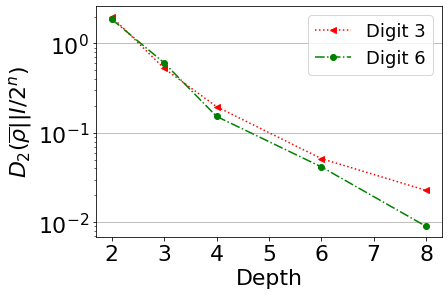

In [9]:
fig = plt.figure(1)
ax = axes([0.15, 0.15, 0.8, 0.8])


def average_encode_state(train_x):
    d1, d2 = train_x.shape
    density_matrices = np.reshape(train_x, [d1, d2, 1]) @ np.reshape(np.conj(train_x), [d1, 1, d2])
    return np.mean(density_matrices, axis=0)


depth_list = [2, 3, 4, 6, 8]

Q_2Renyi_D3_list = []
Q_2Renyi_D6_list = []

for i,q in enumerate(qubit_num_list):
    train_x, train_y = train_data[i]
    train_x = train_x.numpy()
    
    train_x0 = train_x[train_y == 0]
    train_x1 = train_x[train_y == 1]
    average_state0 = average_encode_state(train_x0.real)
    average_state1 = average_encode_state(train_x1.real)
#     print(average_state)
    Q_2Renyi_D3 = np.log2(np.trace(average_state0 @ average_state0) * 2 ** q)
    Q_2Renyi_D6 = np.log2(np.trace(average_state1 @ average_state1) * 2 ** q)
#     bound = np.sum(np.sqrt(S0)) ** 2 / 2 ** num_qubits
    Q_2Renyi_D3_list.append(Q_2Renyi_D3)
    Q_2Renyi_D6_list.append(Q_2Renyi_D6)

print(Q_2Renyi_D3_list)
print(Q_2Renyi_D6_list)


func3, = ax.plot(depth_list, Q_2Renyi_D3_list, linewidth=1.5,
                 marker="<",
                 linestyle=":",
                 color="r"
                 )

func6, = ax.plot(depth_list, Q_2Renyi_D6_list, linewidth=1.5,
                 marker="o",
                 linestyle="-.",
                 color="g"
                 )

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlabel("Depth", fontsize=22)
plt.ylabel(r"$D_2(\overline{\rho} || I/2^n)$", fontsize=22)
ax.semilogy()
ax.legend(handles=[func3, func6],
          labels=["Digit 3", "Digit 6"],
          loc="best",
          fontsize=18)
ax.grid(axis="y")
plt.show()

### Investigating the effect on classification accuracy

[array([0.675], dtype=float32), array([0.61], dtype=float32), array([0.585], dtype=float32), array([0.535], dtype=float32), array([0.475], dtype=float32)]


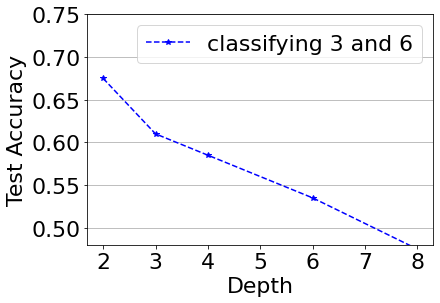

In [10]:
print(acc_list)

fig = plt.figure(1)
ax = axes([0.15, 0.15, 0.8, 0.8])

func36_acc, = ax.plot(depth_list, acc_list, linewidth=1.5,
                      marker="*",
                      linestyle="--",
                      color="b"
                      )

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.48, 0.75)
plt.xlabel("Depth", fontsize=22)
plt.ylabel(r"Test Accuracy", fontsize=22)
ax.legend(handles=[func36_acc,],
          labels=["classifying 3 and 6"],
          loc="best", fontsize=22)
ax.grid(axis="y")
plt.show()

## Conclusion

According to the experimental results, the average quantum state of each category tends to the maximum mixed state at an exponential rate as the data encoding circuit deepens. As a result, the final quantum neural network's classification accuracy decreases. With the help of the literature [5], we have come to understand some of the limitations of angle coding. It is also acknowledged that designing a data coding strategy capable of solving real-world problems (often with high dimensionality of data features) is both urgent and difficult.

---
## References

[1] Schuld, M. "Quantum machine learning models are kernel methods." [arXiv preprint arXiv:2101.11020.(2021)](https://arxiv.org/abs/2101.11020)

[2] Lloyd, Seth, et al. "Quantum embeddings for machine learning." [arXiv preprint arXiv:2001.03622 (2020).](https://arxiv.org/pdf/2001.03622.pdf)

[3] Caro, Matthias C., et al. "Encoding-dependent generalization bounds for parametrized quantum circuits." [Quantum 5 (2021): 582.](https://quantum-journal.org/papers/q-2021-11-17-582/)

[4] Leonardo Banchi, et al. "Generalization in quantum machine learning: A quantum information standpoint." [PRX Quantum 2.4 (2021): 040321.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040321)

[5] Li, Guangxi, et al. "Concentration of Data Encoding in Parameterized Quantum Circuits." [arXiv preprint arXiv:2206.08273 (2022).](https://arxiv.org/pdf/2206.08273.pdf)
